<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-и-анализ-данных" data-toc-modified-id="Предобработка-и-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка и анализ данных</a></span></li><li><span><a href="#Построение базовой-нейронной-сети" data-toc-modified-id="Построение базовой-нейронной-сети-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение базовой нейронной сети</a></span></li><li><span><a href="#Улучшение-нейронной-сети" data-toc-modified-id="Улучшение-нейронной-сети-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Улучшение нейронной сети</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

 # Прогнозирование температуры звезды
 
 Необходимо определить температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
 - Закон смещения Вина.
 - Закон Стефана-Больцмана.
 - Спектральный анализ.    
 
 Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.    

#### Характеристики

- Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
- Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (`white, red, blue, yellow, yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды:

|Тип звезды |Номер, соответствующий типу|
|:-----------|---------------------------:|
|Коричневый карлик|0|
|Красный карлик|	1|
|Белый карлик|	2|
|Звёзды главной последовательности|	3|
|Сверхгигант|	4|
|Гипергигант|	5|

- Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.    
  


>💡 Справочная информация:    
> - Светимость Солнца (англ. _Average Luminosity of Sun_ )    
>$L_0 = 3.828*10^{26}Вт$    
> - Радиус Солнца (англ. _Average Radius of Sun_ )    
>$R_0 = 6.9551*10^8м$

## Загрузка данных

In [1]:
# загрузим необходимые бибилиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import ceil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
import random

In [2]:
# загрузим данные
data = pd.read_csv("/datasets/6_class.csv", index_col=0)
data.info()
display(data.sample(5))
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
230,24145,382993.00000,1494.000,-8.84,5,Blue-white
10,3600,0.00290,0.510,10.69,1,Red
70,3345,0.02100,0.273,12.30,1,Red
168,17383,342900.00000,30.000,-6.09,4,Blue
122,3218,0.00054,0.110,20.02,0,Red


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Есть лишний столбец с индексом, его удалили при загрузке данных.    
Нет пропусков, всего 240 строк есть категориальные и количественные данные.

## Предобработка и анализ данных

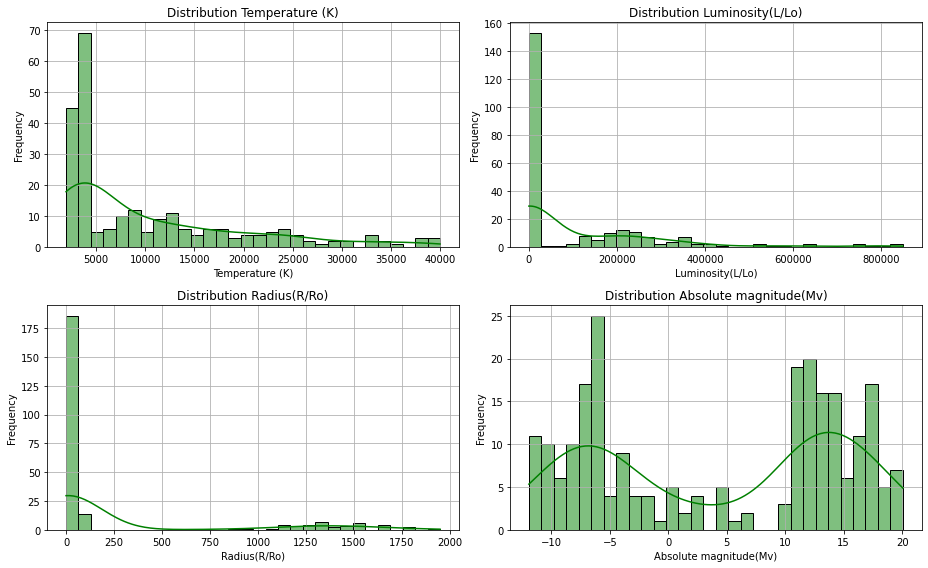

In [3]:
# построим гистограммы для количественных значений
num_data = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

plt.figure(figsize=(13, 8))
for i, p in enumerate(num_data, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[p], bins=30, kde=True, color='g')
    plt.title(f'Distribution {p}')
    plt.xlabel(p)
    plt.ylabel('Frequency')
    plt.grid()

plt.tight_layout()
plt.show()

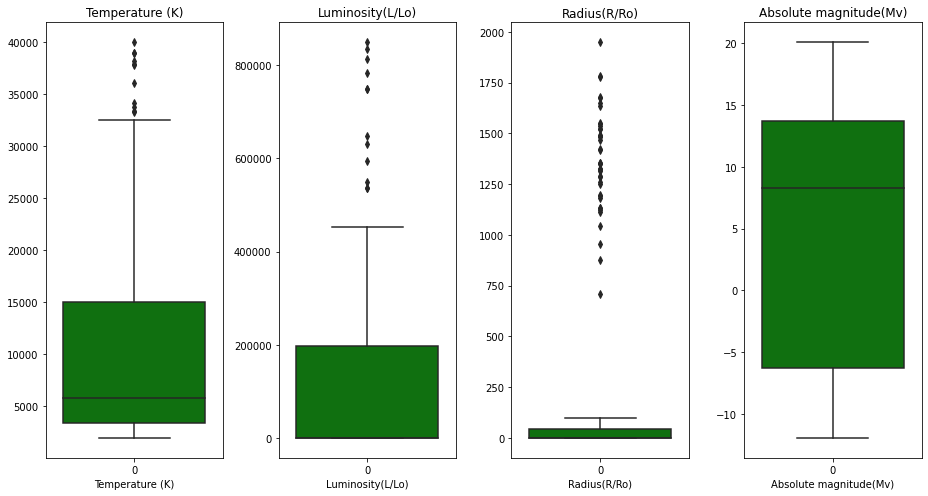

In [4]:
# ящики с усами
plt.figure(figsize=(13, 7))
for i, p in enumerate(num_data, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=data[p], color='g')
    plt.title(f'{p}')
    plt.xlabel(p)

plt.tight_layout()
plt.show()

- `Temperature(K)` - большинство звёзд имеют температуру около `3-15` тысяч Kельвина, есть выбросы;
- `Luminosity(L/Lo)` - больше половины звёзд имеет светимость меньше светимости Солнца, есть выбросы;
- `Radius(R/Ro)` - больше половины звёзд имеют радиус меньше радиуса Солнца, есть выбросы;
- `Absolute magnitude(Mv)` - значения абсолютной звёздной величины распределены от `-11.92` до `20.06`.


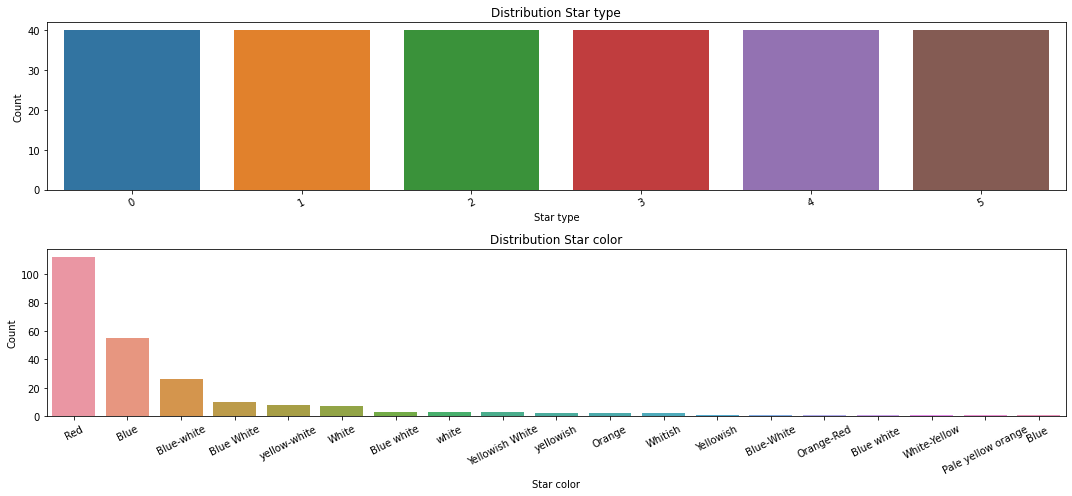

In [7]:
# построим графики для категориальных значений
cat_data = ['Star type', 'Star color']

plt.figure(figsize=(15, 7))
for i, p in enumerate(cat_data, 1):
    plt.subplot(2, 1, i)
    sns.countplot(data=data, x=p, order=data[p].value_counts().index)
    plt.title(f'Distribution {p}')
    plt.xlabel(p)
    plt.ylabel('Count')
    plt.xticks(rotation=27)

plt.tight_layout()
plt.show()

In [8]:
# исправим записи цвета звёзд
df = data.copy()
df['Star color'] = df['Star color'].str.strip().str.lower().replace({
                                                                     r'.*orange.*': 'yellow',
                                                                      'yellowish': 'yellow',
                                                                      'whitish': 'white',
                                                                      ' ': '-',
                                                                      'white-yellow': 'yellow-white'
                                                                    }, regex=True)

df['Star color'].value_counts()

red             112
blue             56
blue-white       41
white            12
yellow-white     12
yellow            7
Name: Star color, dtype: int64

В данных отражено одинаковое количество типов звёзд: каждого типа по `40` .    
Цвета звёзд привели к общему виду и упростили.

In [10]:
# закодируем, масшабируем и разделим данные
df.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(df.drop('temperature', axis=1),
                                                    df['temperature'], test_size=0.2,
                                                    random_state=random_state, shuffle=True)

cat_features = ['star_type', 'star_color'] 

ohe_encoder = OneHotEncoder(drop='first', sparse=False)

train_temp = ohe_encoder.fit_transform(X_train[cat_features]) 
X_train[ohe_encoder.get_feature_names()] = train_temp 
X_train.drop(cat_features, axis=1, inplace=True) 

test_temp = ohe_encoder.transform(X_test[cat_features]) 
X_test[ohe_encoder.get_feature_names()] = test_temp 
X_test.drop(cat_features, axis=1, inplace=True) 
display(X_test.sample())

scaler = StandardScaler()
num_features = ['luminosity', 'radius', 'absolute_magnitude']
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

display(X_test.sample())

,luminosity,radius,absolute_magnitude,x0_1,x0_2,x0_3,x0_4,x0_5,x1_blue-white,x1_red,x1_white,x1_yellow,x1_yellow-white
230,382993.0,1494.0,-8.84,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


,luminosity,radius,absolute_magnitude,x0_1,x0_2,x0_3,x0_4,x0_5,x1_blue-white,x1_red,x1_white,x1_yellow,x1_yellow-white
172,3.166247,2.232643,-1.341648,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Построение базовой нейронной сети

In [11]:
# создадим класс нейронной сети
class BasNN(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64], activations=[nn.ReLU()]):
        super(BasNN, self).__init__()       
        layers = []
        for units, activation in zip(hidden_layers, activations):
            layers.extend([nn.Linear(input_dim, units), activation])
            input_dim = units
        layers.append(nn.Linear(hidden_layers[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [12]:
# функция для обучения модели
torch.manual_seed(42)
def train_nn(model, X_train, y_train, X_val, y_val, learning_rate=0.001, epochs=2000, batch_size=1000):
    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
    X_val_tensor = torch.FloatTensor(X_val.values)
    y_val_tensor = torch.FloatTensor(y_val.values).view(-1, 1)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        indices = list(range(len(X_train)))
        random.shuffle(indices)
        X_train_tensor = X_train_tensor[indices]
        y_train_tensor = y_train_tensor[indices]
        
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = torch.sqrt(criterion(val_outputs, y_val_tensor))
        model.train()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val RMSE: {val_loss.item():.4f}")
    
    return model

In [13]:
# обучение модели
input_dim = X_train.shape[1]
model = BasNN(input_dim, hidden_layers=[64, 32], activations=[nn.ReLU(), nn.ReLU()])
model = train_nn(model, X_train, y_train, X_test, y_test)

# предсказания
predicted_test = model(torch.FloatTensor(X_test.values)).detach().numpy()

Epoch [1/2000], Loss: 193168304.0000, Val RMSE: 15253.0693
Epoch [2/2000], Loss: 193167920.0000, Val RMSE: 15253.0527
Epoch [3/2000], Loss: 193167536.0000, Val RMSE: 15253.0371
Epoch [4/2000], Loss: 193167104.0000, Val RMSE: 15253.0195
Epoch [5/2000], Loss: 193166672.0000, Val RMSE: 15253.0020
Epoch [6/2000], Loss: 193166256.0000, Val RMSE: 15252.9854
Epoch [7/2000], Loss: 193165824.0000, Val RMSE: 15252.9668
Epoch [8/2000], Loss: 193165376.0000, Val RMSE: 15252.9492
Epoch [9/2000], Loss: 193164912.0000, Val RMSE: 15252.9297
Epoch [10/2000], Loss: 193164464.0000, Val RMSE: 15252.9111
Epoch [11/2000], Loss: 193163984.0000, Val RMSE: 15252.8916
Epoch [12/2000], Loss: 193163520.0000, Val RMSE: 15252.8721
Epoch [13/2000], Loss: 193163008.0000, Val RMSE: 15252.8516
Epoch [14/2000], Loss: 193162512.0000, Val RMSE: 15252.8320
Epoch [15/2000], Loss: 193161984.0000, Val RMSE: 15252.8105
Epoch [16/2000], Loss: 193161472.0000, Val RMSE: 15252.7891
Epoch [17/2000], Loss: 193160912.0000, Val RMSE: 

In [14]:
# обучение модели
input_dim = X_train.shape[1]
model = BasNN(input_dim, hidden_layers=[150, 20, 9], activations=[nn.Tanh(), nn.LeakyReLU(), nn.LeakyReLU()])
model = train_nn(model, X_train, y_train, X_test, y_test)

# предсказания
predicted_test = model(torch.FloatTensor(X_test.values)).detach().numpy()    

Epoch [1/2000], Loss: 193163920.0000, Val RMSE: 15252.9102
Epoch [2/2000], Loss: 193163472.0000, Val RMSE: 15252.8936
Epoch [3/2000], Loss: 193163008.0000, Val RMSE: 15252.8760
Epoch [4/2000], Loss: 193162576.0000, Val RMSE: 15252.8613
Epoch [5/2000], Loss: 193162160.0000, Val RMSE: 15252.8447
Epoch [6/2000], Loss: 193161712.0000, Val RMSE: 15252.8281
Epoch [7/2000], Loss: 193161232.0000, Val RMSE: 15252.8086
Epoch [8/2000], Loss: 193160752.0000, Val RMSE: 15252.7900
Epoch [9/2000], Loss: 193160240.0000, Val RMSE: 15252.7715
Epoch [10/2000], Loss: 193159728.0000, Val RMSE: 15252.7510
Epoch [11/2000], Loss: 193159152.0000, Val RMSE: 15252.7275
Epoch [12/2000], Loss: 193158576.0000, Val RMSE: 15252.7061
Epoch [13/2000], Loss: 193157952.0000, Val RMSE: 15252.6807
Epoch [14/2000], Loss: 193157296.0000, Val RMSE: 15252.6553
Epoch [15/2000], Loss: 193156592.0000, Val RMSE: 15252.6279
Epoch [16/2000], Loss: 193155888.0000, Val RMSE: 15252.6016
Epoch [17/2000], Loss: 193155120.0000, Val RMSE: 

Подобрана сеть c наилучшими результатами `RMSE: 4162.5` :  
- 3 скрытых слоя: `[nn.Tanh(), nn.LeakyReLU(), nn.LeakyReLU()]` ,
- количество нейронов, соответственно: `[150, 20, 9]` .

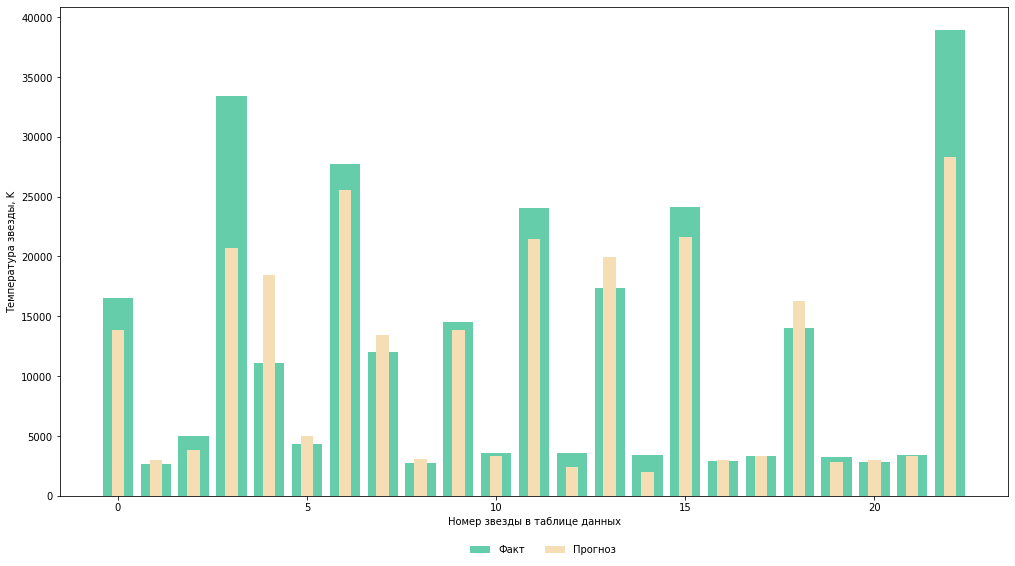

In [15]:
# график «Факт — Прогноз»
def graph_fact_pred (pred, targ):
    test_preds = pd.DataFrame(pred, columns=['temperature'])[:23]
    test_target = pd.DataFrame(targ.values.reshape([-1]), columns=['temperature'])[:23]
    fig, ax = plt.subplots(figsize=[17,9])
    ax.patch.set_alpha(0.3)
    plt.bar(x=test_target.index, height=test_target['temperature'], color='mediumaquamarine', label='Факт')
    plt.bar(x=test_preds.index, height=test_preds['temperature'], color='wheat' , label='Прогноз', width= 0.33)
    plt.xlabel('Номер звезды в таблице данных')
    plt.ylabel('Температура звезды, K')
    fig.legend(loc='lower center', bbox_to_anchor=(0.22, 0.02, 0.6, 0), ncol=2, frameon = 0)
    plt.show()
graph_fact_pred(predicted_test, y_test)    

Нейросеть даёт неплохие результаты.
Наилучшее значение метрики `RMSE` на тестовой выборке - `4162.5`.

## Улучшение нейронной сети

In [16]:
class AdvanceBasNN(nn.Module):
    def __init__(self, input_dim, hidden_layers=[150, 20, 9],
                 activations=[nn.Tanh(), nn.LeakyReLU(), nn.LeakyReLU()], dropout_prob=0.2):
        super(AdvanceBasNN, self).__init__()
        
        layers = []
        for units, activation in zip(hidden_layers, activations):
            layers.extend([nn.Linear(input_dim, units), activation, nn.Dropout(p=dropout_prob)])
            input_dim = units
        
        layers.append(nn.Linear(hidden_layers[-1], 1))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_nnn(model, X_train, y_train, X_val, y_val, learning_rate=0.001, epochs=2000, batch_size=1000):
    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
    X_val_tensor = torch.FloatTensor(X_val.values)
    y_val_tensor = torch.FloatTensor(y_val.values).view(-1, 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        indices = list(range(len(X_train)))
        random.shuffle(indices)
        X_train_tensor = X_train_tensor[indices]
        y_train_tensor = y_train_tensor[indices]
        
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = torch.sqrt(criterion(val_outputs, y_val_tensor))
        
        model.train()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val RMSE: {val_loss.item():.4f}")
    
    return model

input_dim2 = X_train.shape[1]
model2 = AdvanceBasNN(input_dim, hidden_layers=[150, 20, 9],
                     activations=[nn.Tanh(), nn.LeakyReLU(), nn.LeakyReLU()],
                     dropout_prob=0.1)
model2 = train_nnn(model2, X_train, y_train, X_test, y_test, batch_size=500, learning_rate=0.001)

predicted_test_2 = model2(torch.FloatTensor(X_test.values)).detach().numpy()

Epoch [1/2000], Loss: 193171344.0000, Val RMSE: 15253.1885
Epoch [2/2000], Loss: 193171184.0000, Val RMSE: 15253.1826
Epoch [3/2000], Loss: 193171008.0000, Val RMSE: 15253.1768
Epoch [4/2000], Loss: 193170832.0000, Val RMSE: 15253.1699
Epoch [5/2000], Loss: 193170736.0000, Val RMSE: 15253.1641
Epoch [6/2000], Loss: 193170576.0000, Val RMSE: 15253.1553
Epoch [7/2000], Loss: 193170384.0000, Val RMSE: 15253.1475
Epoch [8/2000], Loss: 193170176.0000, Val RMSE: 15253.1367
Epoch [9/2000], Loss: 193169984.0000, Val RMSE: 15253.1279
Epoch [10/2000], Loss: 193169808.0000, Val RMSE: 15253.1152
Epoch [11/2000], Loss: 193169536.0000, Val RMSE: 15253.1045
Epoch [12/2000], Loss: 193169232.0000, Val RMSE: 15253.0908
Epoch [13/2000], Loss: 193168896.0000, Val RMSE: 15253.0762
Epoch [14/2000], Loss: 193168592.0000, Val RMSE: 15253.0625
Epoch [15/2000], Loss: 193168304.0000, Val RMSE: 15253.0459
Epoch [16/2000], Loss: 193167920.0000, Val RMSE: 15253.0293
Epoch [17/2000], Loss: 193167504.0000, Val RMSE: 

In [17]:
# подбор параметров batch_size и dropout_prob 
input_dim2 = X_train.shape[1]
model2 = AdvanceBasNN(input_dim, hidden_layers=[150, 20, 9],
                     activations=[nn.Tanh(), nn.LeakyReLU(), nn.LeakyReLU()],
                     dropout_prob=0.2)
model2 = train_nnn(model2, X_train, y_train, X_test, y_test, batch_size=60, learning_rate=0.001)

predicted_test_2 = model2(torch.FloatTensor(X_test.values)).detach().numpy()

Epoch [1/2000], Loss: 113975192.0000, Val RMSE: 15253.2627
Epoch [2/2000], Loss: 150250240.0000, Val RMSE: 15253.2402
Epoch [3/2000], Loss: 93878904.0000, Val RMSE: 15253.2246
Epoch [4/2000], Loss: 263601408.0000, Val RMSE: 15253.2061
Epoch [5/2000], Loss: 235868736.0000, Val RMSE: 15253.1875
Epoch [6/2000], Loss: 139383248.0000, Val RMSE: 15253.1680
Epoch [7/2000], Loss: 156008144.0000, Val RMSE: 15253.1445
Epoch [8/2000], Loss: 157645776.0000, Val RMSE: 15253.1152
Epoch [9/2000], Loss: 116179040.0000, Val RMSE: 15253.0762
Epoch [10/2000], Loss: 370910368.0000, Val RMSE: 15253.0283
Epoch [11/2000], Loss: 163355024.0000, Val RMSE: 15252.9629
Epoch [12/2000], Loss: 55759872.0000, Val RMSE: 15252.8770
Epoch [13/2000], Loss: 233976784.0000, Val RMSE: 15252.7686
Epoch [14/2000], Loss: 129050488.0000, Val RMSE: 15252.6299
Epoch [15/2000], Loss: 198292672.0000, Val RMSE: 15252.4512
Epoch [16/2000], Loss: 372381088.0000, Val RMSE: 15252.2207
Epoch [17/2000], Loss: 196999344.0000, Val RMSE: 15

Подобрана сеть c наилучшими результатами `RMSE: 4156.3403` :  
- `batch_size`: `60` ,
- `dropout_prob`: `0.2` .

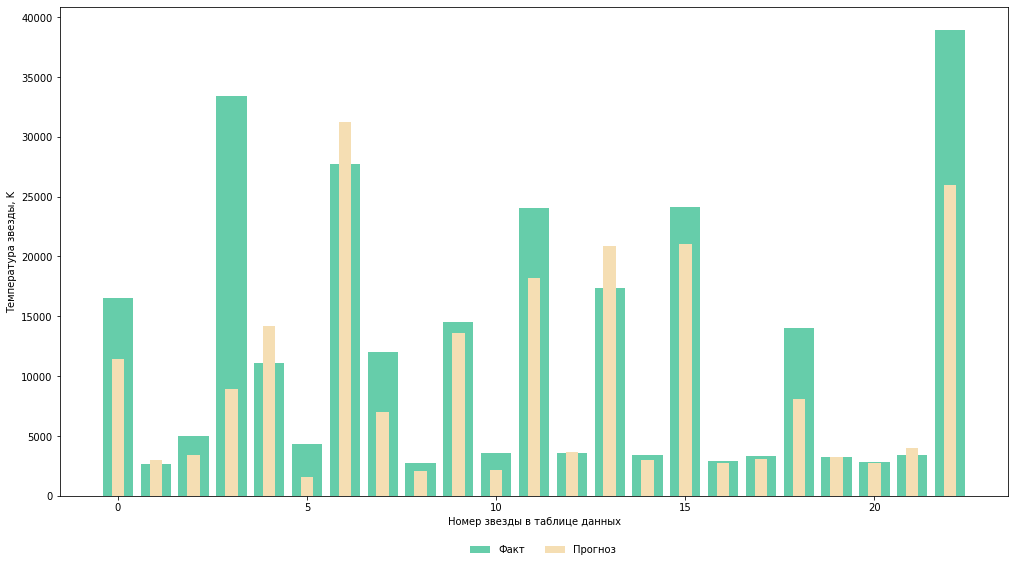

In [18]:
# график «Факт — Прогноз» на сети с улучшениями
graph_fact_pred(predicted_test_2, y_test)    

## Выводы

Гиперпараметры нейронной сети:
- `input_dim`: определяется количеством признаков во входных данных;
- `hidden_layers`: `[150, 20, 9]`, количество нейронов в каждом скрытом слое;
- `activations`: `[nn.Tanh(), nn.LeakyReLU(), nn.LeakyReLU()]`, определяют активацию каждого скрытого слоя;
- `dropout_prob`: `0.2`, что указывает на то, что 20% нейронов в выпадающих слоях будут отброшены случайным образом;
- `learning_rate`: `0.001`, скорость обучения;
- `epochs`: `2000`, количество эпох;
- `batch_size`: `62` — размер батча.

Целевая метрика RMSE достигнута.